# Capstone Project – Finding a Better Place in Scarborough, Toronto

### Installing and Importing Python Libraries and Dependencies

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import lxml.html as lh
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install geocoder
!pip install folium
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Data Extraction and Cleaning

In [2]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

#Create a handle, page, to handle the contents of the website
page = requests.get(url)

#Store the contents of the website under doc
doc = lh.fromstring(page.content)

#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

In [3]:
# Parse the first row as our header
tr_elements = doc.xpath('//tr')

#Create empty list
col=[]
i=0

#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    print ('%d:"%s"'%(i,name))
    col.append((name,[]))

1:"Postal Code
"
2:"Borough
"
3:"Neighbourhood
"


In [4]:
#Since out first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 3, the //tr data is not from our table 
    if len(T)!=3:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

In [5]:
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)

In [6]:
# Access the top 5 rows of the data frame 
df.head()

,Postal Code\n,Borough\n,Neighbourhood\n
0,M1A\n,Not assigned\n,Not assigned\n
1,M2A\n,Not assigned\n,Not assigned\n
2,M3A\n,North York\n,Parkwoods\n
3,M4A\n,North York\n,Victoria Village\n
4,M5A\n,Downtown Toronto\n,"Regent Park, Harbourfront\n"


In [7]:
df.columns = ['Postal Code', 'Borough', 'Neighbourhood']
#Cleaning the messy string in columns
df = df.replace('\n',' ', regex=True)
#Dropping all cells with a borough that is Not assigned
df.drop(df.index[df['Borough'].str.contains('Not assigned')], inplace = True)

df = df.reset_index(drop=True)

df.head(10)

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [8]:
#Combining Neighbourhoods based on similar Postalcode and Borough
df = df.groupby(['Postal Code', 'Borough'])['Neighbourhood'].apply(','.join).reset_index()
df.drop(df.index[df['Borough'].str.contains('Canadian postal codes')], inplace = True)
df.loc[df['Neighbourhood'].str.contains('Not assigned'), 'Neighbourhood'] = df['Borough']
df.columns = ['Postal Code','Borough','Neighbourhood']
df.head(10)

,Postal Code,Borough,Neighbourhood
1,M1B,Scarborough,"Malvern, Rouge"
2,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
3,M1E,Scarborough,"Guildwood, Morningside, West Hill"
4,M1G,Scarborough,Woburn
5,M1H,Scarborough,Cedarbrae
6,M1J,Scarborough,Scarborough Village
7,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"
8,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge"
9,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"
10,M1N,Scarborough,"Birch Cliff, Cliffside West"


#### Longitude and Latitude dataframe

In [9]:
link = "http://cocl.us/Geospatial_data"
df1 = pd.read_csv(link)

df1.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [10]:
df1.shape

(103, 3)

In [11]:
df.shape

(103, 3)

Both the data frames have 103 rows and 3 columns

#### Merging the two data frames together based on their Postal Code

In [12]:
link = 'https://raw.githubusercontent.com/seshaphani17/Coursera_Capstone/main/Locationcoordinates.csv'
df_location = pd.read_csv(link)

df_location.head(10)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


#### Find how many boroughs and neighborhoods

In [13]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_location['Borough'].unique()),
        df_location.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


#### Use geopy library to get the latitude and longitude values of Scarborough,Toronto

In [14]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.773077, -79.257774.


#### Create a map of scarborough to visualize the neighbourhoods

In [15]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_location['Latitude'], df_location['Longitude'], df_location['Borough'], df_location['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Utilizing the Foursquare API to explore the neighborhoods and segment them

In [16]:
# Define Foursquare Credentials and Version
LIMIT = 100

CLIENT_ID = 'NVT0O25EZXJROTFZAM1BEX1KQ3R4VX50MB4JSJ03Y3JIUXXV' # your Foursquare ID
CLIENT_SECRET = 'AV0KB40DKOZVZLA0GKSBSOJ2X3AKYNSTS3QRVL540ULZNY3J' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NVT0O25EZXJROTFZAM1BEX1KQ3R4VX50MB4JSJ03Y3JIUXXV
CLIENT_SECRET:AV0KB40DKOZVZLA0GKSBSOJ2X3AKYNSTS3QRVL540ULZNY3J


In [17]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
latitude1 = location.latitude
longitude1 = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude1, longitude1))

The geograpical coordinate of Toronto are 43.773077, -79.257774.


In [18]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude1, 
   longitude1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

#### Nearby Venues of Scarborough 

In [19]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups',
       'venue.location.neighborhood', 'venue.venuePage.id'],
      dtype='object')

In [20]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [21]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775017,-79.258109
1,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
2,American Eagle Store,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776012,-79.258334
3,St. Andrews Fish & Chips,"[{'id': '4edd64a0c7ddd24ca188df1a', 'name': 'F...",43.771865,-79.252645
4,Chipotle Mexican Grill,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",43.776410,-79.258069


#### Removing the messy values from columns 

In [22]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,SEPHORA,Cosmetics Shop,43.775017,-79.258109
1,Disney Store,Toy / Game Store,43.775537,-79.256833
2,American Eagle Store,Clothing Store,43.776012,-79.258334
3,St. Andrews Fish & Chips,Fish & Chips Shop,43.771865,-79.252645
4,Chipotle Mexican Grill,Mexican Restaurant,43.776410,-79.258069


#### Top 10 Categories of venue 

In [23]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store      7
Coffee Shop         6
Restaurant          4
Sandwich Place      2
Gas Station         2
Department Store    2
Pharmacy            2
Supermarket         1
Bank                1
Toy / Game Store    1
Name: categories, dtype: int64

# Explore Neighborhoods in Scarborough

#### Let's create a function to repeat the same process to all the neighborhoods in Scarborough

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called scarborough_venues.

In [25]:
# Nearby Venues
Scarborough_venues = getNearbyVenues(names=df_location['Neighbourhood'],
                                   latitudes=df_location['Latitude'],
                                   longitudes=df_location['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

#### Let's find out how many unique categories can be curated from all the returned venues 

In [26]:

print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()


There are 322 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,12,12,12,12,12,12
"Alderwood, Long Branch",10,10,10,10,10,10
"Bathurst Manor, Wilson Heights, Downsview North",23,23,23,23,23,23
Bayview Village,8,8,8,8,8,8
"Bedford Park, Lawrence Manor East",29,29,29,29,29,29


#### One hot encoding 

In [27]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Resta

#### Let's print each neighborhood along with the top 5 most common venues 

In [28]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
             venue  freq
0  Motorcycle Shop  0.08
1      Coffee Shop  0.08
2     Skating Rink  0.08
3           Lounge  0.08
4   Breakfast Spot  0.08


---- Alderwood, Long Branch ----
               venue  freq
0  Convenience Store   0.2
1        Pizza Place   0.2
2                Pub   0.1
3        Gas Station   0.1
4           Pharmacy   0.1


---- Bathurst Manor, Wilson Heights, Downsview North ----
         venue  freq
0         Bank  0.09
1  Coffee Shop  0.09
2   Restaurant  0.04
3  Supermarket  0.04
4  Bridal Shop  0.04


---- Bayview Village ----
                 venue  freq
0                 Bank  0.25
1  Japanese Restaurant  0.12
2         Intersection  0.12
3         Skating Rink  0.12
4        Grocery Store  0.12


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0  Italian Restaurant  0.10
1         Coffee Shop  0.10
2      Sandwich Place  0.07
3            Pharmacy  0.03
4           Juice Bar  0.03


---- Berczy Park ----
       

           venue  freq
0       Pharmacy  0.22
1  Shopping Mall  0.11
2     Playground  0.11
3           Bank  0.11
4  Grocery Store  0.11


---- Kennedy Park, Ionview, East Birchmount Park ----
            venue  freq
0     Coffee Shop  0.21
1    Intersection  0.07
2   Train Station  0.07
3  Discount Store  0.07
4  Sandwich Place  0.07


---- Kensington Market, Chinatown, Grange Park ----
                           venue  freq
0                           Café  0.08
1                            Bar  0.08
2  Vegetarian / Vegan Restaurant  0.06
3                    Coffee Shop  0.04
4             Mexican Restaurant  0.04


---- Kingsview Village, St. Phillips, Martin Grove Gardens, Richview Gardens ----
            venue  freq
0    Intersection  0.08
1      Beer Store  0.08
2     Pizza Place  0.08
3  Sandwich Place  0.08
4     Gas Station  0.08


---- Lawrence Manor, Lawrence Heights ----
                    venue  freq
0          Clothing Store  0.17
1             Coffee Shop  0.07
2   V

            venue  freq
0            Café  0.07
1     Coffee Shop  0.06
2  Sandwich Place  0.03
3             Bar  0.03
4       Bookstore  0.03


---- Victoria Village ----
                 venue  freq
0                 Park  0.12
1  Sporting Goods Shop  0.12
2          Pizza Place  0.12
3           Playground  0.12
4          Coffee Shop  0.12


---- West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale ----
               venue  freq
0        Pizza Place  0.50
1            Theater  0.25
2  Convenience Store  0.25
3         Nail Salon  0.00
4    Organic Grocery  0.00


---- Westmount ----
                venue  freq
0  Golf Driving Range  0.09
1        Intersection  0.09
2         Golf Course  0.09
3  Chinese Restaurant  0.09
4      Discount Store  0.09


---- Weston ----
                 venue  freq
0                 Park  0.17
1        Grocery Store  0.17
2  Fried Chicken Joint  0.17
3                Diner  0.17
4             Pharmacy  0.17


---- Wexford, Maryvale 

### Let's put that into a pandas dataframe

First, let's write a function to sort the venues in descending order. 

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


#### Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Pool Hall,Coffee Shop,Badminton Court,Breakfast Spot,Latin American Restaurant,Sandwich Place,Skating Rink,Lounge,Clothing Store,Motorcycle Shop
1,"Alderwood, Long Branch",Convenience Store,Pizza Place,Pub,Coffee Shop,Sandwich Place,Pharmacy,Gas Station,Gym,Event Space,Ethiopian Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Diner,Deli / Bodega,Bridal Shop,Mobile Phone Shop,Supermarket,Sushi Restaurant,Shopping Mall,Fried Chicken Joint
3,Bayview Village,Bank,Chinese Restaurant,Café,Japanese Restaurant,Grocery Store,Intersection,Skating Rink,Women's Store,Eastern European Restaurant,Drugstore
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Italian Restaurant,Sandwich Place,Cosmetics Shop,Butcher,Pizza Place,Café,Locksmith,Liquor Store,Sushi Restaurant


## Cluster Neighborhoods

Run k-means to cluster the neighborhood into 5 clusters.

In [31]:
# set number of clusters
kclusters = 5

Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Scarborough_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 2, 3, 3, 3, 3, 0, 3, 3, 3], dtype=int32)

#### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [32]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged =df_location.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

Scarborough_merged.head()# check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,3,Fast Food Restaurant,Coffee Shop,Hobby Shop,Spa,Women's Store,Ethiopian Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,1,Breakfast Spot,Bar,Burger Joint,Women's Store,Falafel Restaurant,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,2,Park,Restaurant,Fast Food Restaurant,Fried Chicken Joint,Electronics Store,Moving Target,Beer Store,Thrift / Vintage Store,Intersection,Greek Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0,Park,Coffee Shop,Construction & Landscaping,Convenience Store,Business Service,Ethiopian Restaurant,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,3,Indian Restaurant,Coffee Shop,Thai Restaurant,Caribbean Restaurant,Chinese Restaurant,Gas Station,Athletics & Sports,Asian Restaurant,Bank,Hakka Restaurant


In [33]:
kclusters = 10

Finally, let's visualize the resulting clusters

In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighbourhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


## Examine Clusters

In [35]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

### Average Housing Price in Scarborough and Bar Graph 

In [36]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_location["Neighbourhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})


In [37]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

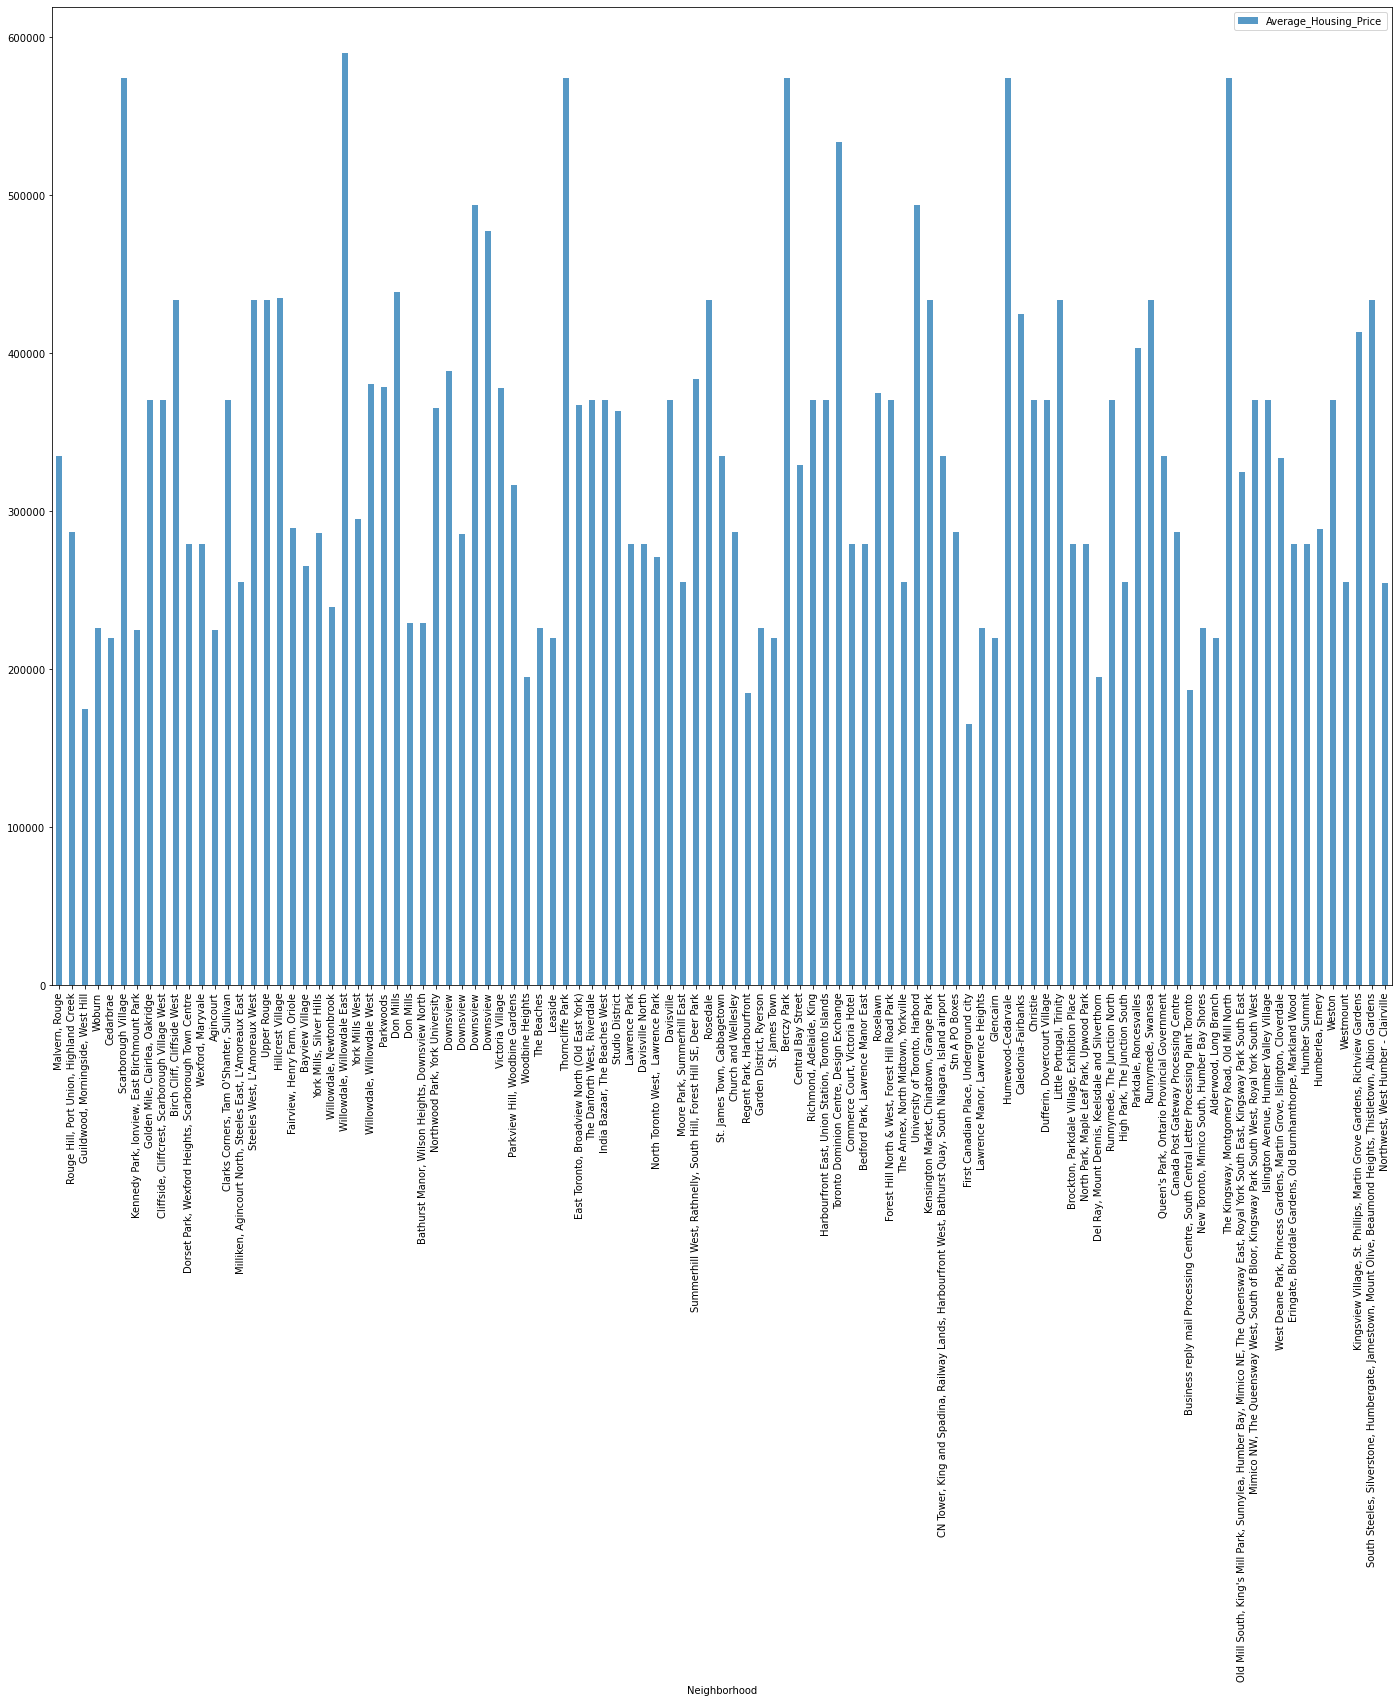

In [38]:
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

## School Rating by Clusters

In [39]:
clusters=pd.DataFrame({"Cluster1":df1["Neighbourhood"],
                      "Cluster2":df2["Neighbourhood"],
                      "Cluster4":df3["Neighbourhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [40]:
new_Scarborough=Scarborough_merged.set_index("Neighbourhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df["Neighbourhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

In [41]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

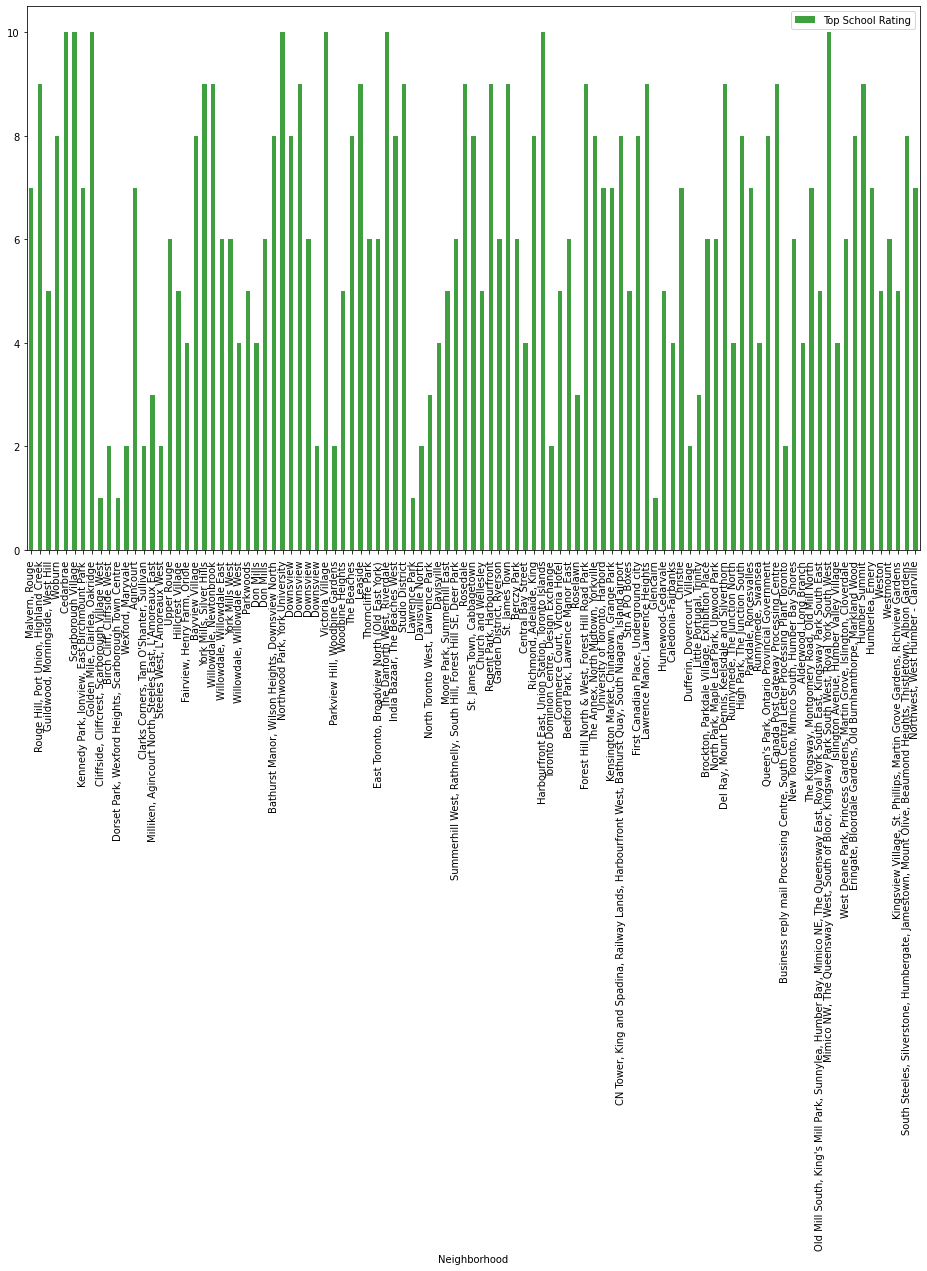

In [42]:
Scarborough_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);

## Conclusion: 

In this project, using k-means cluster algorithm I separated the neighborhood into 10(Ten) different clusters and for 103 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made.